# SUSTAV ZA DETEKCIJU KARAKTERISTIČNIH TOČAKA LICA - demo

Pokreće se izvršavanjem svih ćelija u ovom notebook-u.  
Dodatno se može zadnja ćelija pokrenuti više puta kako bi se prikazao **rad sustava na različitim slikama**. 

Potrebno je u direktoriju imati model ***model_demo.h5***.
  
#### Toni Polanec 2023.


In [7]:

import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import load_model


### Korištene metode:

In [8]:
def plot_mult_images(image_array, landmarks, rows = 3, cols = 3):
    default_pics = [random.randint(0, len(image_array)) for i in range(rows*cols)]
    index = 0

    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            ax[row,col].imshow(image_array[default_pics[index]], cmap='gray')
            ax[row,col].scatter(landmarks.iloc[default_pics[index],0::2], landmarks.iloc[default_pics[index],1::2], c="#0f0", marker='+')
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' %(default_pics[index]),fontsize=10)
            index += 1


def plot_predicted_image(images, truth, prediction, index):
    print(index, "->" , prediction[index])
    plt.imshow(images[index], cmap='gray')
    plt.scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='P')
    plt.scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='P')
    plt.legend(["Truth","Prediction"])
    plt.show()
    

def plot_predicted_images(images, truth, prediction, with_truth=False, random_indexes=True):
    prediction_no_truth = [851, 866, 142, 1241, 1171, 651, 1376, 89, 139]
    prediciton_truth = [73, 501, 277, 189, 644, 268, 679, 864, 452]

    if random_indexes:
        indexes = [random.randint(0, len(images))-1 for i in range(9)]
    else:
        if with_truth:
            indexes = prediciton_truth
        else:
            indexes = prediction_no_truth

    rows = 3
    cols = 3

    arr_i = 0
    fig, ax = plt.subplots(rows,cols,sharex=True,sharey=True,figsize=[cols*2,rows*2])
    for row in range(rows):
        for col in range(cols):
            index = indexes[arr_i]
            ax[row,col].imshow(images[index], cmap='gray')
            if with_truth:
                ax[row,col].scatter(truth.iloc[index, 0::2], truth.iloc[index, 1::2], c="#0f0", marker='+')
            ax[row,col].scatter(prediction[index, 0::2], prediction[index, 1::2], c="#f00", marker='+')
            ax[row,col].set_title('image index = %d' %(index),fontsize=10)
            arr_i += 1

### Priprema podataka:

In [9]:
# učitanje slika
face_images = np.load('face_images.npz')
faces=face_images.get(face_images.files[0]) 
# oblikovanje polja
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)


landmarks = pd.read_csv('facial_keypoints.csv')
# brisanje podataka o obrvama i ustima (osim bottom_lip_center)
landmarks = landmarks.drop(['left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y'], axis=1)

# brisanje slika koje nemaju sve točke a malo ih je
empty_rows = landmarks[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']].isnull().any(axis=1)
null_indexes = landmarks[empty_rows].index

# brisanje slika koje imaju te određene točke s null vrijednostima
faces = np.delete(faces, null_indexes, axis=0)
landmarks = landmarks.dropna(subset=['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'], how='any')

# imputacija 
landmarks_null = landmarks[landmarks.isnull().any(axis=1)]
landmarks_not_null = landmarks.dropna()
not_null_size = landmarks_not_null.shape[0]

left_eye_inner_corner_x_avg_diff = (landmarks_not_null['left_eye_inner_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_inner_corner_y_avg_diff = (landmarks_not_null['left_eye_inner_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

left_eye_outer_corner_x_avg_diff = (landmarks_not_null['left_eye_outer_corner_x'].values - landmarks_not_null['left_eye_center_x'].values).sum() / not_null_size
left_eye_outer_corner_y_avg_diff = (landmarks_not_null['left_eye_outer_corner_y'].values - landmarks_not_null['left_eye_center_y'].values).sum() / not_null_size

right_eye_inner_corner_x_avg_diff = (landmarks_not_null['right_eye_inner_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_inner_corner_y_avg_diff = (landmarks_not_null['right_eye_inner_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

right_eye_outer_corner_x_avg_diff = (landmarks_not_null['right_eye_outer_corner_x'].values - landmarks_not_null['right_eye_center_x'].values).sum() / not_null_size
right_eye_outer_corner_y_avg_diff = (landmarks_not_null['right_eye_outer_corner_y'].values - landmarks_not_null['right_eye_center_y'].values).sum() / not_null_size

mouth_center_top_lip_x_avg_diff = (landmarks_not_null['mouth_center_top_lip_x'].values - landmarks_not_null['mouth_center_bottom_lip_x'].values).sum() / not_null_size
mouth_center_top_lip_y_avg_diff = (landmarks_not_null['mouth_center_top_lip_y'].values - landmarks_not_null['mouth_center_bottom_lip_y'].values).sum() / not_null_size

landmarks['left_eye_inner_corner_x'] = landmarks['left_eye_inner_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_inner_corner_x_avg_diff)
landmarks['left_eye_inner_corner_y'] = landmarks['left_eye_inner_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_inner_corner_y_avg_diff)

landmarks['left_eye_outer_corner_x'] = landmarks['left_eye_outer_corner_x'].fillna(landmarks['left_eye_center_x'] + left_eye_outer_corner_x_avg_diff)
landmarks['left_eye_outer_corner_y'] = landmarks['left_eye_outer_corner_y'].fillna(landmarks['left_eye_center_y'] + left_eye_outer_corner_y_avg_diff)

landmarks['right_eye_inner_corner_x'] = landmarks['right_eye_inner_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_inner_corner_x_avg_diff)
landmarks['right_eye_inner_corner_y'] = landmarks['right_eye_inner_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_inner_corner_y_avg_diff)

landmarks['right_eye_outer_corner_x'] = landmarks['right_eye_outer_corner_x'].fillna(landmarks['right_eye_center_x'] + right_eye_outer_corner_x_avg_diff)
landmarks['right_eye_outer_corner_y'] = landmarks['right_eye_outer_corner_y'].fillna(landmarks['right_eye_center_y'] + right_eye_outer_corner_y_avg_diff)

landmarks['mouth_center_top_lip_x'] = landmarks['mouth_center_top_lip_x'].fillna(landmarks['mouth_center_bottom_lip_x'] + mouth_center_top_lip_x_avg_diff)
landmarks['mouth_center_top_lip_y'] = landmarks['mouth_center_top_lip_y'].fillna(landmarks['mouth_center_bottom_lip_y'] + mouth_center_top_lip_y_avg_diff)

# normalizacija
faces = faces/255

# podjela na train i test
train_x,test_x,train_y,test_y = train_test_split(faces, landmarks, test_size=0.2, random_state=42)


### Vizualizacija podataka:  
Više puta pokrenuti za prikaz različitih slika.

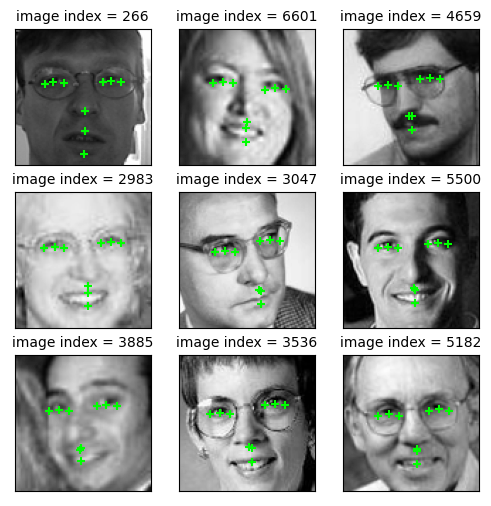

In [10]:
plot_mult_images(faces, landmarks)

### Učitavanje modela:

In [11]:
model = load_model('model_demo.h5')


In [12]:
print("Evaluacija modela: ")
model.evaluate(test_x, test_y)
print("Predikcija: ")
y_pred = model.predict(test_x)


Evaluacija modela: 
44/44 [==============================] - 2s 49ms/step - loss: 20.4330 - mean_squared_error: 20.4330
Predikcija: 
44/44 [==============================] - 2s 51ms/step


### Prikaz rezultata:

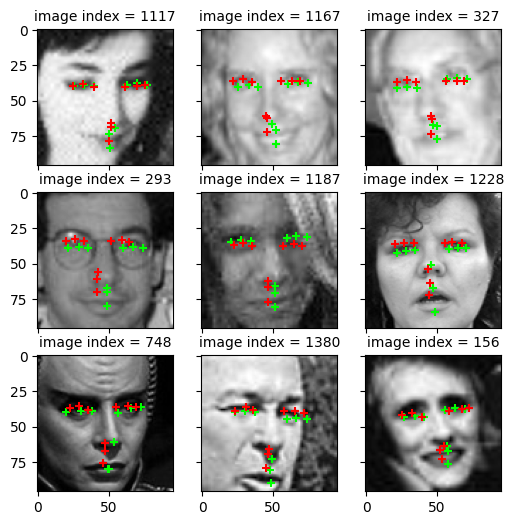

In [13]:
'''
with_truth 
    True - prikazuje slike sa predviđenim i stvarnim točkama
    False - prikazuje slike samo sa predviđenim točkama

random_indexes
    True - prikazuje nasumične slike
    False - prikazuje od prije odabrane slike

zeleni +  stvarne točke 
crveni +  predikcija modela
'''

plot_predicted_images(test_x, test_y, y_pred, with_truth=True, random_indexes=True)